# Loading pre-trained BeigeBERT model

In [ ]:
### Load the pre-trained model for fine-tuning

from transformers import RobertaTokenizer, RobertaForSequenceClassification

# Define the local path to the pre-trained model
model_path = "C:/Users/MCOB PHD 14/Documents/Dissertation prep/path_to_save_model/beige_book_pretrained"
# Load the tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained(model_path)
model = RobertaForSequenceClassification.from_pretrained(model_path, num_labels=13)

# Move the model to the appropriate device (GPU or CPU)
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at C:/Users/MCOB PHD 14/Documents/Dissertation prep/path_to_save_model/beige_book_pretrained and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

## Getting data ready

In [12]:
####### Prepare dataset

import pandas as pd
from sklearn.model_selection import train_test_split

# Load your dataset
data_path = "C:/Users/MCOB PHD 14/Documents/Dissertation prep/Data/labeled_beige_books_with_text.csv"
labeled_data = pd.read_csv(data_path)

# Convert binary labels to integers if needed
topics = [
    "Employment", "Prices", "Consumption", "Manufacturing", "Construction",
    "Lending", "Uncertainty", "Resources", "Transportation", "Outlook",
    "Labor", "Capital", "Trade"
]
labeled_data[topics] = labeled_data[topics].astype(int)

# Ensure text column is valid
labeled_data['text'] = labeled_data['text'].fillna("").astype(str)

# Split into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    labeled_data['text'].tolist(),
    labeled_data[topics].values,
    test_size=0.2,
    random_state=42
)


##### Tokenize the text data

def tokenize_function(texts):
    return tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )

# Tokenize training and validation texts
train_encodings = tokenize_function(train_texts)
val_encodings = tokenize_function(val_texts)

# Convert labels to tensors
train_labels = torch.tensor(train_labels, dtype=torch.float32)
val_labels = torch.tensor(val_labels, dtype=torch.float32)

# Create DataLoader objects

from torch.utils.data import Dataset, DataLoader

class BeigeBookDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

# Create Dataset objects
train_dataset = BeigeBookDataset(train_encodings, train_labels)
val_dataset = BeigeBookDataset(val_encodings, val_labels)

# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

## Fine-tuning (this takes awhile)

In [13]:
import torch
from transformers import AdamW
from torch.nn import BCEWithLogitsLoss
from tqdm import tqdm
from sklearn.metrics import f1_score
import numpy as np

# Initialize optimizer and loss function
optimizer = AdamW(model.parameters(), lr=5e-5)
loss_fn = BCEWithLogitsLoss()

# Initialize learning rate scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2, verbose=True)

# Early stopping parameters
patience = 3
early_stop_counter = 0
best_val_loss = float("inf")

# To track metrics
training_losses = []
validation_losses = []
f1_scores = []

# Training loop
epochs = 10
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")

    # Training phase
    model.train()
    train_loss = 0
    loop = tqdm(train_loader, leave=True)

    for batch in loop:
        optimizer.zero_grad()
        
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits  # Shape: [batch_size, num_labels]
        
        # Compute loss
        loss = loss_fn(logits, labels)
        train_loss += loss.item()
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Update progress bar
        loop.set_description(f"Epoch {epoch + 1}")
        loop.set_postfix(loss=loss.item())

    # Average training loss for the epoch
    avg_train_loss = train_loss / len(train_loader)
    training_losses.append(avg_train_loss)
    print(f"Training Loss: {avg_train_loss:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            # Compute validation loss
            loss = loss_fn(logits, labels)
            val_loss += loss.item()

            # Collect predictions and true labels
            predictions = (torch.sigmoid(logits).cpu().numpy() > 0.5).astype(int)
            all_predictions.append(predictions)
            all_labels.append(labels.cpu().numpy())

    # Average validation loss
    avg_val_loss = val_loss / len(val_loader)
    validation_losses.append(avg_val_loss)
    print(f"Validation Loss: {avg_val_loss:.4f}")

    # Compute F1 score for validation set
    all_predictions = np.vstack(all_predictions)
    all_labels = np.vstack(all_labels)
    f1 = f1_score(all_labels, all_predictions, average="macro", zero_division=1)
    f1_scores.append(f1)
    print(f"Validation F1 Score: {f1:.4f}")

    # Learning rate scheduler step
    scheduler.step(avg_val_loss)

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stop_counter = 0
        # Optionally save the model if it improves
        torch.save(model.state_dict(), "best_model.pth")
        print("Model improved. Saving...")
    else:
        early_stop_counter += 1
        print(f"Early stop counter: {early_stop_counter}/{patience}")

    if early_stop_counter >= patience:
        print("Early stopping triggered. Training stopped.")
        break

c:\Users\MCOB PHD 14\anaconda3\envs\pytorch_env\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Epoch 1/10


Epoch 1: 100%|██████████| 51/51 [05:13<00:00,  6.16s/it, loss=0.288]


Training Loss: 0.3143
Validation Loss: 0.3296
Validation F1 Score: 0.4495
Model improved. Saving...

Epoch 2/10


Epoch 2: 100%|██████████| 51/51 [05:13<00:00,  6.14s/it, loss=0.206]


Training Loss: 0.2621
Validation Loss: 0.3280
Validation F1 Score: 0.5131
Model improved. Saving...

Epoch 3/10


Epoch 3: 100%|██████████| 51/51 [05:09<00:00,  6.07s/it, loss=0.305]


Training Loss: 0.2252
Validation Loss: 0.3145
Validation F1 Score: 0.5406
Model improved. Saving...

Epoch 4/10


Epoch 4: 100%|██████████| 51/51 [04:50<00:00,  5.69s/it, loss=0.138]


Training Loss: 0.1838
Validation Loss: 0.3115
Validation F1 Score: 0.5893
Model improved. Saving...

Epoch 5/10


Epoch 5: 100%|██████████| 51/51 [04:31<00:00,  5.32s/it, loss=0.147]


Training Loss: 0.1618
Validation Loss: 0.3007
Validation F1 Score: 0.6061
Model improved. Saving...

Epoch 6/10


Epoch 6: 100%|██████████| 51/51 [04:38<00:00,  5.46s/it, loss=0.142] 


Training Loss: 0.1448
Validation Loss: 0.3118
Validation F1 Score: 0.6093
Early stop counter: 1/3

Epoch 7/10


Epoch 7: 100%|██████████| 51/51 [04:36<00:00,  5.43s/it, loss=0.0796]


Training Loss: 0.1251
Validation Loss: 0.2961
Validation F1 Score: 0.6226
Model improved. Saving...

Epoch 8/10


Epoch 8: 100%|██████████| 51/51 [04:28<00:00,  5.26s/it, loss=0.082] 


Training Loss: 0.1057
Validation Loss: 0.2823
Validation F1 Score: 0.6290
Model improved. Saving...

Epoch 9/10


Epoch 9: 100%|██████████| 51/51 [04:27<00:00,  5.24s/it, loss=0.042] 


Training Loss: 0.0920
Validation Loss: 0.2960
Validation F1 Score: 0.6177
Early stop counter: 1/3

Epoch 10/10


Epoch 10: 100%|██████████| 51/51 [04:25<00:00,  5.21s/it, loss=0.0725]


Training Loss: 0.0824
Validation Loss: 0.3048
Validation F1 Score: 0.6587
Early stop counter: 2/3


## Evaluating results

In [18]:
# Load back in the best saved model (epoch 8 in this case)
# Load the best model weights
model.load_state_dict(torch.load("best_model.pth"))
model.to(device)

C:\Users\MCOB PHD 14\AppData\Local\Temp\ipykernel_17732\1322636957.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [19]:
# Collect predictions and true labels from the validation set
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Convert logits to probabilities, then to binary predictions
        predictions = (torch.sigmoid(logits).cpu().numpy() > 0.5).astype(int)

        # Collect predictions and true labels
        all_predictions.append(predictions)
        all_labels.append(labels.cpu().numpy())

# Combine all batches into a single NumPy array
all_predictions = np.vstack(all_predictions)
all_labels = np.vstack(all_labels)


In [21]:
from sklearn.metrics import accuracy_score, hamming_loss, jaccard_score, precision_score, recall_score, f1_score

# Subset accuracy (exact match ratio)
subset_accuracy = accuracy_score(all_labels, all_predictions)

# Hamming loss
ham_loss = hamming_loss(all_labels, all_predictions)

# Jaccard Index (macro-averaged)
jaccard = jaccard_score(all_labels, all_predictions, average="macro")

# Precision, recall, F1 score (macro-averaged)
precision = precision_score(all_labels, all_predictions, average="macro", zero_division=1)
recall = recall_score(all_labels, all_predictions, average="macro", zero_division=1)
f1 = f1_score(all_labels, all_predictions, average="macro", zero_division=1)

# Display metrics
print(f"Subset Accuracy: {subset_accuracy:.4f}")
print(f"Hamming Loss: {ham_loss:.4f}")
print(f"Jaccard Index: {jaccard:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Subset Accuracy: 0.2745
Hamming Loss: 0.1109
Jaccard Index: 0.4834
Precision: 0.7464
Recall: 0.5716
F1 Score: 0.6290


In [ ]:
# Results by epoch

# Print all metrics
print("Training Losses:", training_losses)
print("Validation Losses:", validation_losses)
print("F1 Scores:", f1_scores)

import pandas as pd

# Create a DataFrame to store the metrics
metrics_df = pd.DataFrame({
    "epoch": list(range(1, len(training_losses) + 1)),
    "training_loss": training_losses,
    "validation_loss": validation_losses,
    "f1_score": f1_scores,
})

# Save to CSV
#metrics_df.to_csv("training_metrics.csv", index=False)
#print("Metrics saved to training_metrics.csv")

# Load metrics from CSV
metrics_df = pd.read_csv("training_metrics.csv")
print(metrics_df)


Training Losses: [0.3142508934525883, 0.262063328834141, 0.22521339590642966, 0.18382606845276028, 0.16181348337262286, 0.1448080671184203, 0.12510867635993397, 0.10568183821206, 0.09196166431202608, 0.0824331216075841]
Validation Losses: [0.3296093184214372, 0.327981982093591, 0.31454218236299664, 0.31150454397384936, 0.3007209197832988, 0.3118082605875455, 0.29607716317360216, 0.28231278634988344, 0.2959906653716014, 0.304824105822123]
F1 Scores: [0.44950175948771676, 0.5131365894523789, 0.5406236882825511, 0.5892648694901005, 0.6060688396297682, 0.6092534621626694, 0.6225828749217618, 0.6289685200836193, 0.617651078831505, 0.6587398640572061]
Metrics saved to training_metrics.csv
   epoch  training_loss  validation_loss  f1_score
0      1       0.314251         0.329609  0.449502
1      2       0.262063         0.327982  0.513137
2      3       0.225213         0.314542  0.540624
3      4       0.183826         0.311505  0.589265
4      5       0.161813         0.300721  0.606069
5 

In [1]:
import pandas as pd

metrics_df = pd.read_csv("training_metrics.csv")
print(metrics_df)

   epoch  training_loss  validation_loss  f1_score
0      1       0.314251         0.329609  0.449502
1      2       0.262063         0.327982  0.513137
2      3       0.225213         0.314542  0.540624
3      4       0.183826         0.311505  0.589265
4      5       0.161813         0.300721  0.606069
5      6       0.144808         0.311808  0.609253
6      7       0.125109         0.296077  0.622583
7      8       0.105682         0.282313  0.628969
8      9       0.091962         0.295991  0.617651
9     10       0.082433         0.304824  0.658740


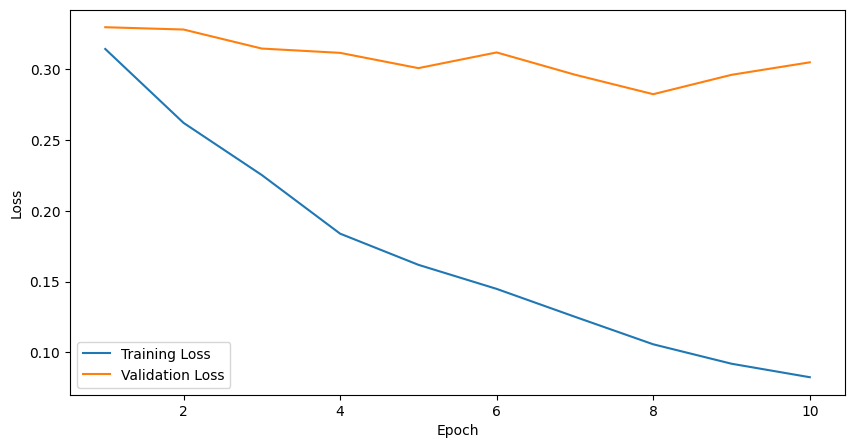

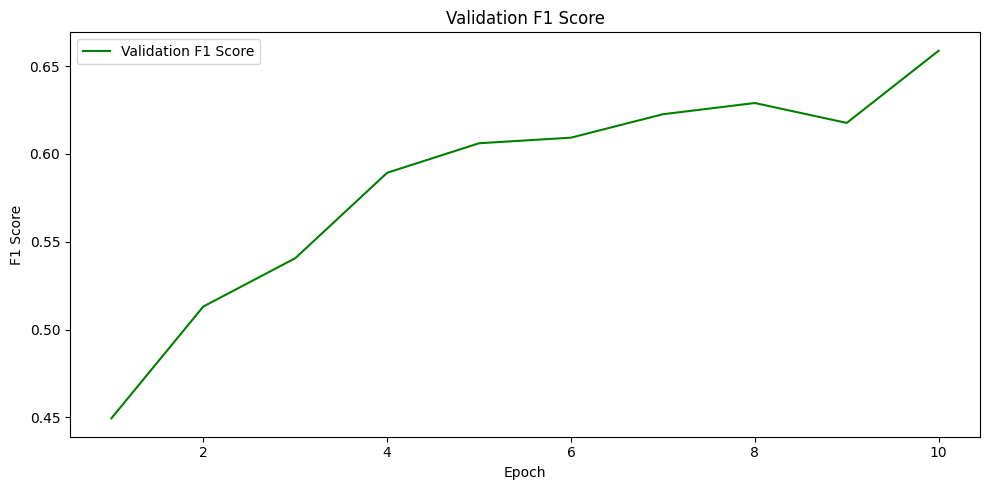

In [5]:
# Visualize the training metrics

import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(metrics_df["epoch"], metrics_df["training_loss"], label="Training Loss")
plt.plot(metrics_df["epoch"], metrics_df["validation_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig("training_loss.png")
plt.show()

# Plot F1 score
plt.figure(figsize=(10, 5))
plt.plot(metrics_df["epoch"], metrics_df["f1_score"], label="Validation F1 Score", color="green")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("Validation F1 Score")
plt.legend()
plt.tight_layout()
plt.show()


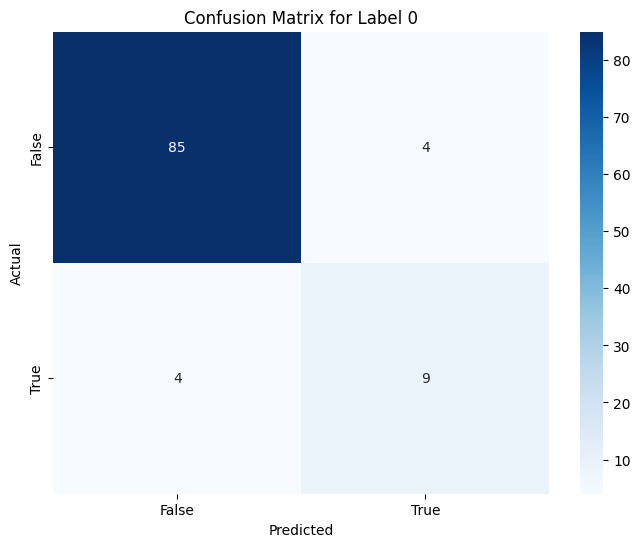

In [34]:
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns

# Example: Confusion matrix for one label
cm = multilabel_confusion_matrix(all_labels[:, 0], all_predictions[:, 0])  # Replace 0 with the index of interest

plt.figure(figsize=(8, 6))
sns.heatmap(cm[1], annot=True, fmt="d", cmap="Blues", xticklabels=["False", "True"], yticklabels=["False", "True"])
plt.title("Confusion Matrix for Label 0")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


## Saving model (only do this if redoing model)

In [ ]:
# Save the best model to a permanent directory
#model.save_pretrained("best_model_epoch_8")
#tokenizer.save_pretrained("best_model_epoch_8")
#print("Best model saved to 'best_model_epoch_8'")


Best model saved to 'best_model_epoch_8'
